# Task 1: Image Segmentation Using Thresholding

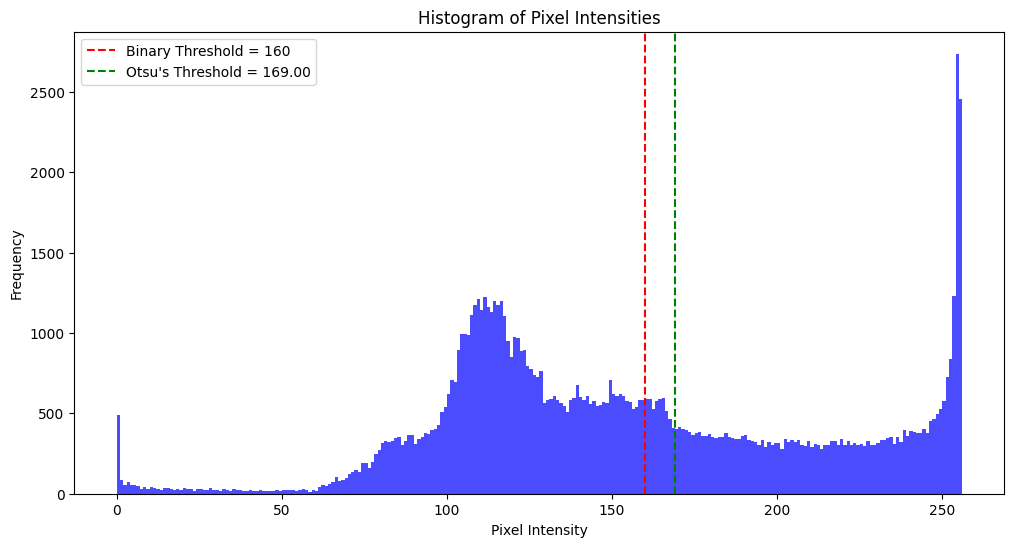

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "images/puppy.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Binary Thresholding
_, binary_thresh = cv2.threshold(image, 160, 255, cv2.THRESH_BINARY)

# Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize=11, C=2
)

# Otsu's Thresholding
_, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Histogram of Pixel Intensities
plt.figure(figsize=(12, 6))
plt.hist(image.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
plt.axvline(x=160, color='red', linestyle='--', label='Binary Threshold = 160')
plt.axvline(x=_, color='green', linestyle='--', label=f"Otsu's Threshold = {_:0.2f}")
plt.title("Histogram of Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()

plt.show()


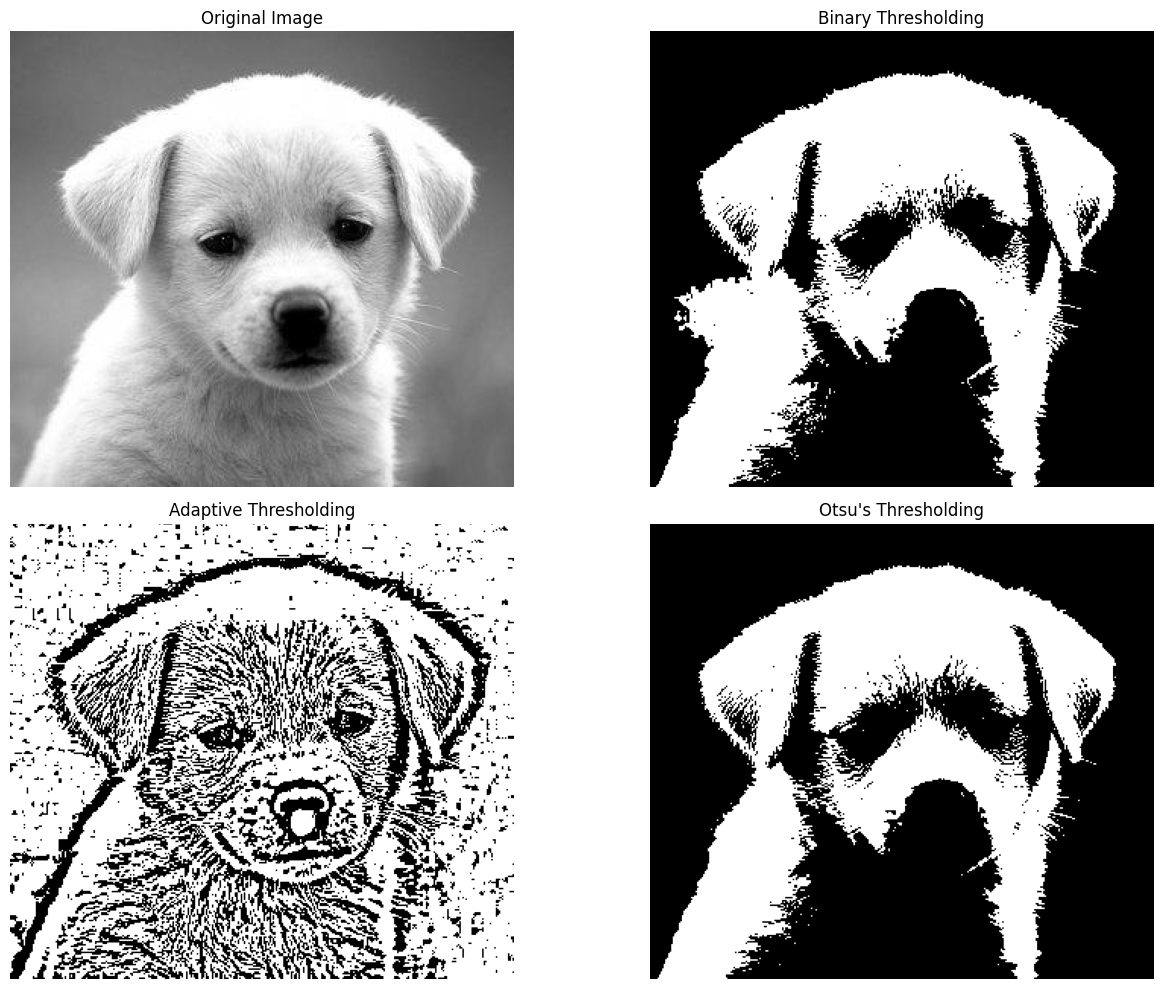

In [4]:
# (b) Display the original and segmented images
plt.figure(figsize=(14, 10))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Binary Thresholding
plt.subplot(2, 2, 2)
plt.imshow(binary_thresh, cmap="gray")
plt.title("Binary Thresholding")
plt.axis("off")

# Adaptive Thresholding
plt.subplot(2, 2, 3)
plt.imshow(adaptive_thresh, cmap="gray")
plt.title("Adaptive Thresholding")
plt.axis("off")

# Otsu's Thresholding
plt.subplot(2, 2, 4)
plt.imshow(otsu_thresh, cmap="gray")
plt.title("Otsu's Thresholding")
plt.axis("off")

plt.tight_layout()
plt.show()

## Analysis
The best segmentation method depends on the image characteristics:

- Binary Thresholding works well for simple images with uniform lighting but struggles with varying brightness.
- Adaptive Thresholding is robust to uneven lighting and produces better results for images with shadows or gradients.
- Otsu’s Thresholding is effective when the image has a bimodal histogram, offering a data-driven threshold that minimizes within-class variance.

Conclusion:\
For an image with uneven lighting or complex boundaries, Adaptive Thresholding generally performs better due to its localized nature. For images with clear bimodal intensity distributions, Otsu’s Thresholding often provides the clearest object boundaries.


# Task 2: Line Detection Using Hough Transform

In [3]:
def detect_lines_hough(image_path, canny_threshold1=50, canny_threshold2=150, hough_threshold=100):
    """
    Detect and highlight straight lines in an image using the Hough Line Transform.
    
    Parameters:
    - image_path: Path to the input image.
    - canny_threshold1: First threshold for the hysteresis procedure in the Canny edge detector.
    - canny_threshold2: Second threshold for the hysteresis procedure in the Canny edge detector.
    - hough_threshold: Accumulator threshold for the Hough Line Transform.
    
    Returns:
    - original_image: The original image.
    - line_image: The processed image with highlighted lines.
    """
    # Load the original image
    original_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, canny_threshold1, canny_threshold2)
    
    # Detect lines using Hough Line Transform
    lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=hough_threshold)
    
    # Create a copy of the original image to draw lines
    line_image = original_image.copy()
    
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    return original_image, line_image


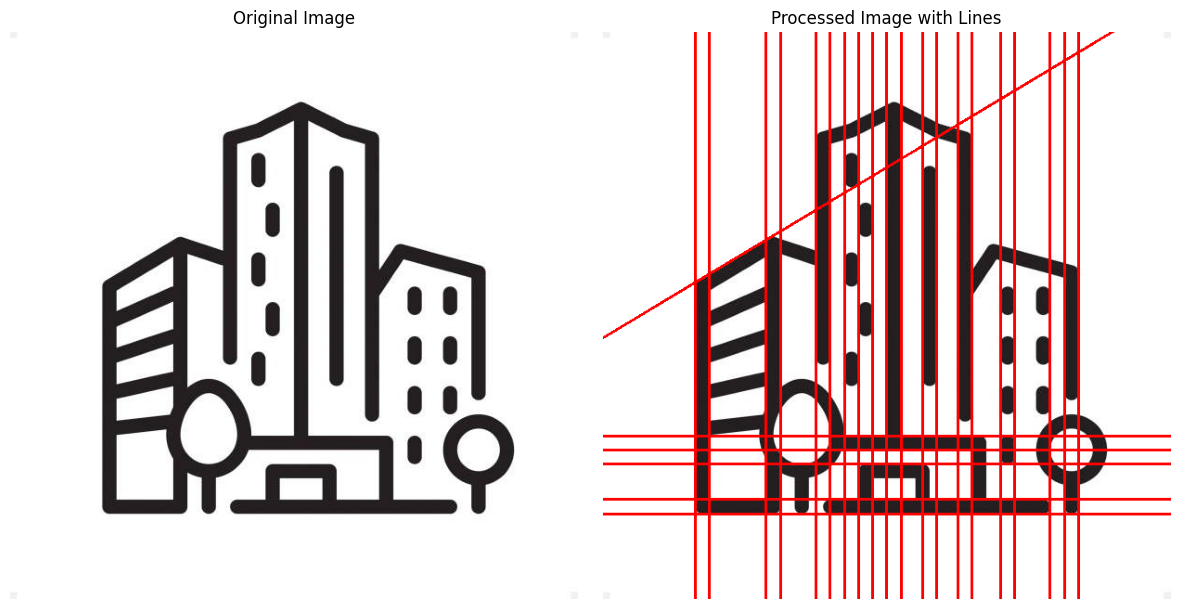

In [4]:
image_path = "images/drawing.jpg" 
original_image, line_image = detect_lines_hough(image_path, 50, 150, 80)

# Display the original and processed images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Processed Image with Highlighted Lines
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Processed Image with Lines")
plt.axis("off")

plt.tight_layout()
plt.show()


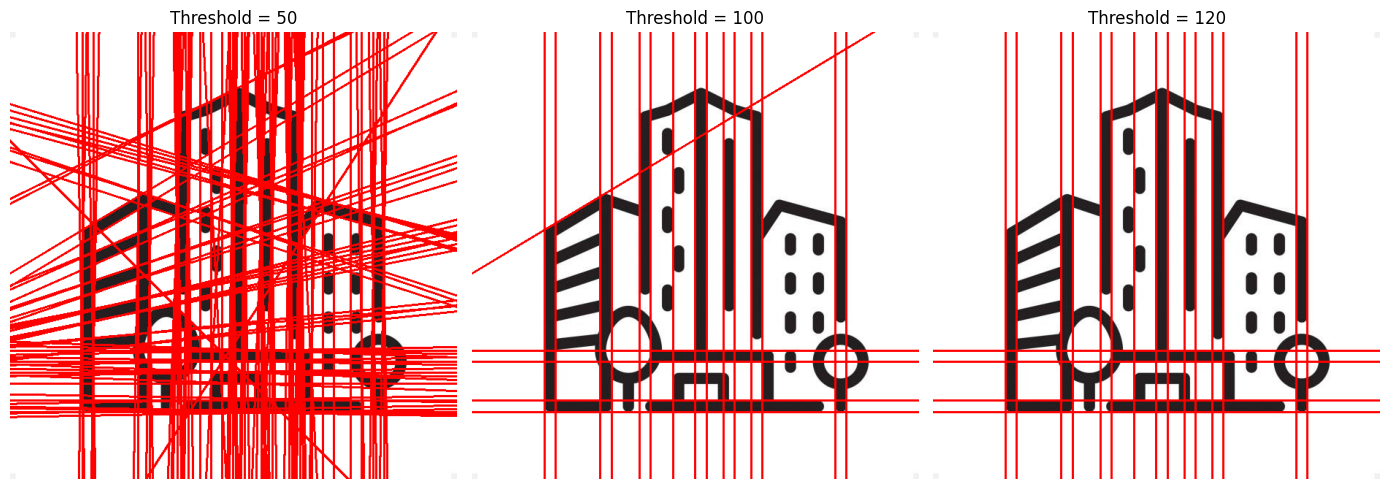

In [10]:
image_path = "images/drawing.jpg" 
original_image, line_image = detect_lines_hough(image_path, 50, 150, 80)

# Experiment with different thresholds
hough_thresholds = [50,100,120]

plt.figure(figsize=(14, 10))

for i, hough_threshold in enumerate(hough_thresholds):
    _, line_image = detect_lines_hough(image_path, 50, 150, hough_threshold)
    
    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Threshold = {hough_threshold}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Key Parameters:

- Canny Thresholds (threshold1, threshold2):
    - Lower values detect more edges, potentially introducing noise.
    - Higher values focus on prominent edges, missing faint ones.
- Hough Transform Threshold:
    - A higher value reduces false positives by requiring stronger line accumulations but may miss weaker lines.
    - A lower value detects more lines, including weak ones, but risks detecting noise.

## Observations:

- Lower Canny thresholds (e.g., 30, 90) detected more edges but included noise, leading to more detected lines.
- Higher Hough thresholds (e.g., 150) filtered out weaker lines, focusing on the most prominent structures.
- The combination of Canny thresholds 50, 150 and a Hough threshold of 80 provided a good balance between detecting relevant lines and minimizing noise.

# Task 3: Circle Detection Using Hough Circle Transform

In [11]:
def detect_circles(image_path, dp=1.2, min_dist=30, param1=50, param2=30, min_radius=0, max_radius=0):
    """
    Detect circles in an image using the Hough Circle Transform.

    Parameters:
    - image_path: Path to the input image.
    - dp: Inverse ratio of the accumulator resolution to the image resolution.
    - min_dist: Minimum distance between the centers of detected circles.
    - param1: First method-specific parameter (higher threshold for Canny edge detection).
    - param2: Second method-specific parameter (accumulator threshold for the circle centers).
    - min_radius: Minimum circle radius to detect.
    - max_radius: Maximum circle radius to detect.

    Returns:
    - original_image: The original image.
    - circle_image: The processed image with detected circles overlaid.
    """
    # Load the original image
    original_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur for smoothing
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
    
    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        blurred_image, 
        cv2.HOUGH_GRADIENT, 
        dp, 
        min_dist, 
        param1=param1, 
        param2=param2, 
        minRadius=min_radius, 
        maxRadius=max_radius
    )
    
    # Create a copy of the original image to draw circles
    circle_image = original_image.copy()
    
    # If circles are detected, draw them on the image
    if circles is not None:
        circles = np.uint16(np.around(circles))  # Round circle parameters to integers
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  # Circle center
            radius = circle[2]  # Circle radius
            cv2.circle(circle_image, center, radius, (0, 255, 0), 2)  # Draw circle perimeter
            cv2.circle(circle_image, center, 2, (0, 0, 255), 3)  # Draw circle center
    
    return original_image, circle_image


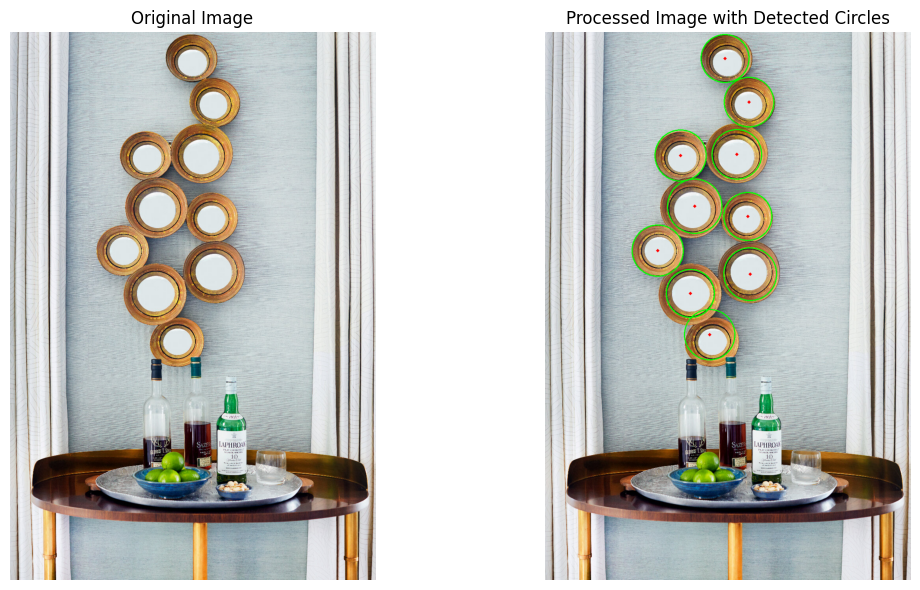

In [12]:
# Test the function on an example image
image_path = "images/wine.jpeg"  # Replace with the path to an image with circular objects
original_image, circle_image = detect_circles(image_path, dp=1.2, min_dist=50, param1=50, param2=30, min_radius=60, max_radius=70)

# Display the original and processed images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Processed Image with Detected Circles
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(circle_image, cv2.COLOR_BGR2RGB))
plt.title("Processed Image with Detected Circles")
plt.axis("off")

plt.tight_layout()
plt.show()


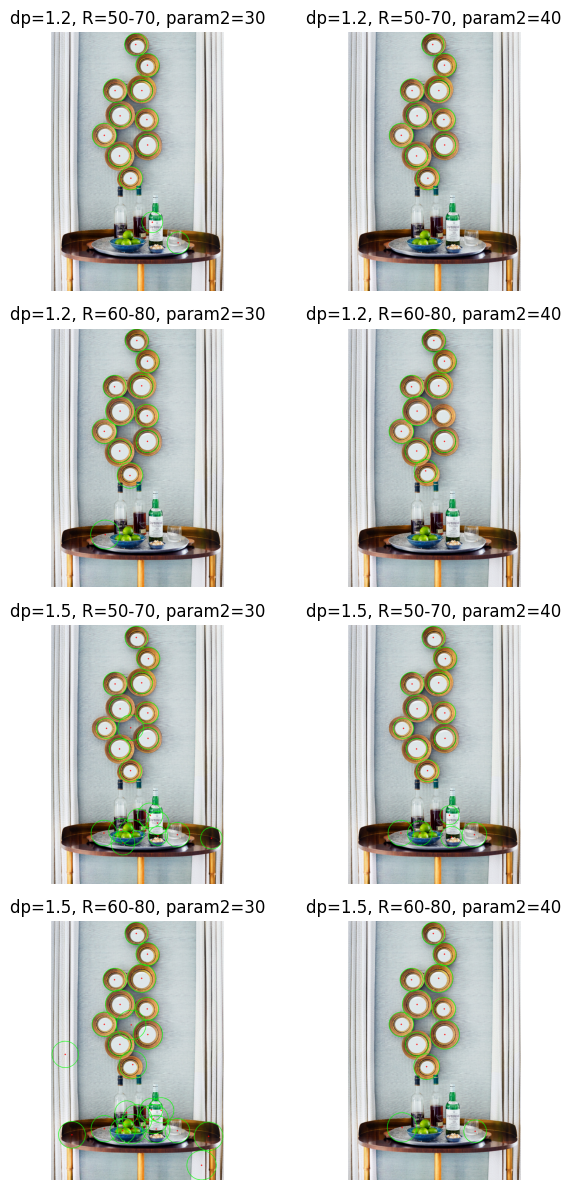

In [13]:
# Experiment with radius ranges and accumulation thresholds
dp_values = [1.2, 1.5]
min_radius_values = [50, 60]
max_radius_values = [70, 80]
param2_values = [30, 40]

plt.figure(figsize=(12, 12))

for i, dp in enumerate(dp_values):
    for j, (min_radius, max_radius) in enumerate(zip(min_radius_values, max_radius_values)):
        for k, param2 in enumerate(param2_values):
            _, circle_image = detect_circles(image_path, dp, 50, 50, param2, min_radius, max_radius)
            
            plt.subplot(4, 4, i*8 + j*4 + k + 1)
            plt.imshow(cv2.cvtColor(circle_image, cv2.COLOR_BGR2RGB))
            plt.title(f"dp={dp}, R={min_radius}-{max_radius}, param2={param2}")
            plt.axis("off")

plt.tight_layout()
plt.show()

## Experimentation with Parameters
- Radius Range (min_radius, max_radius):
    - Setting a narrow range (e.g., min_radius=20, max_radius=50) helps detect circles of known sizes and reduces false positives.
    - A wide range (e.g., min_radius=0, max_radius=0) allows detecting circles of all sizes but may include noise.

- Accumulator Threshold (param2):
    - A higher value (e.g., param2=50) requires stronger evidence to confirm a circle, reducing false positives but missing faint circles.
    - A lower value (e.g., param2=20) detects more circles, including weaker ones, but may introduce noise.

## Observations:

- With Default Parameters: Circles were detected but included some false positives.
- After Adjusting Parameters:
    - Narrowing the radius range improved detection of relevant circles by focusing on the expected sizes.
    - Increasing param2 reduced noise by ensuring only well-defined circles were detected.
- Conclusion: Adjusting parameters such as radius range and accumulator threshold helps refine circle detection, balancing between accuracy and noise reduction.

# Task 4: Harris Corner Detection

In [39]:
def detect_harris_corners(image_path, block_size=2, ksize=3, k=0.04, threshold=0.01):
    """
    Detect and mark corners in an image using the Harris Corner Detection method.
    
    Parameters:
    - image_path: Path to the input image.
    - block_size: Neighborhood size considered for corner detection.
    - ksize: Aperture size for the Sobel operator.
    - k: Harris detector free parameter (sensitivity to corner detection).
    - threshold: Threshold for corner response to consider a point as a corner.
    
    Returns:
    - original_image: The original image.
    - corner_image: The image with marked corners.
    """
    # Load the original image
    original_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    gray_image = np.float32(gray_image)
    
    # Detect corners using Harris Corner Detection
    corners = cv2.cornerHarris(gray_image, block_size, ksize, k)
    
    # Dilate corner image to enhance corner points
    corners = cv2.dilate(corners, None)
    
    # Create a copy of the original image to mark corners
    corner_image = original_image.copy()
    
    # Mark corners on the image
    corner_image[corners > threshold * corners.max()] = [0, 255, 0]  # Mark corners in green
    
    return original_image, corner_image


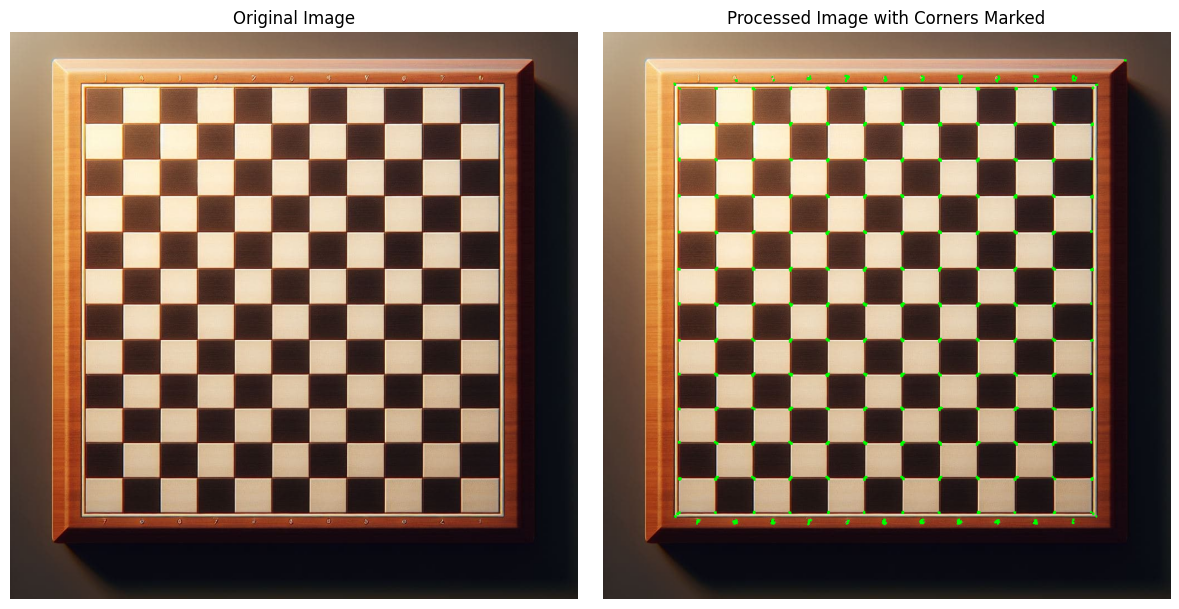

In [42]:
# Test the function on an example image
image_path = "images/chess.jpeg"  # Replace with the path to an image with corners
original_image, corner_image = detect_harris_corners(image_path, block_size=2, ksize=3, k=0.01, threshold=0.01)

# Display the original and processed images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Processed Image with Detected Corners
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
plt.title("Processed Image with Corners Marked")
plt.axis("off")

plt.tight_layout()
plt.show()


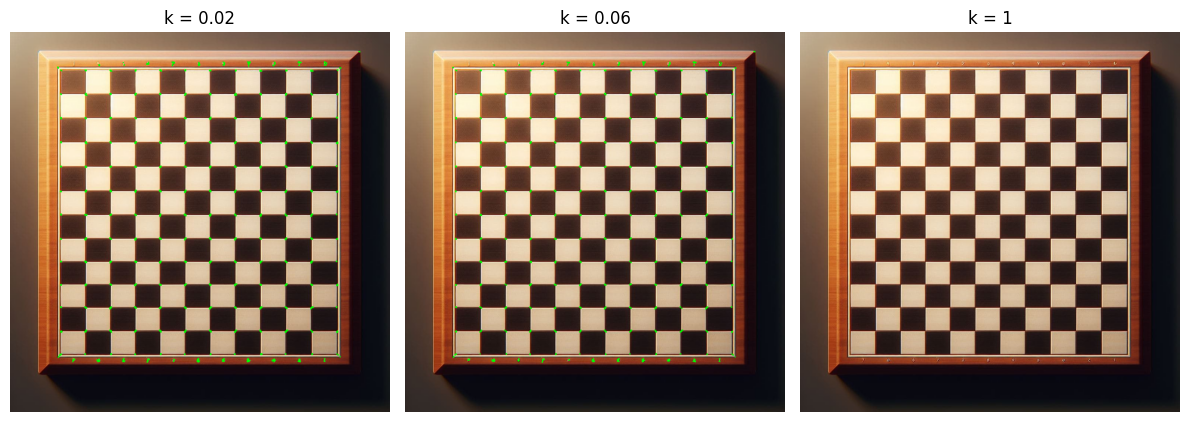

In [43]:
# Vary sensitivity to corner detection

k_values = [0.02, 0.06, 1]

plt.figure(figsize=(12, 6))

for i, k in enumerate(k_values):
    _, corner_image = detect_harris_corners(image_path, block_size=2, ksize=3, k=k, threshold=0.01)
    
    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
    plt.title(f"k = {k}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Impact of Varying the Sensitivity Parameter k:

- Low k Values: Detected a higher number of corners, including some false positives, particularly along edges with steep gradients.
- High k Values: Reduced the number of detected corners, emphasizing only the sharpest and most prominent ones.

Choosing a moderate k value strikes a balance between sensitivity and precision, effectively capturing meaningful corners while minimizing noise. Adjusting k allows for fine-tuning the trade-off between identifying subtle corners and suppressing false detections.

# Task 5: Short Theory

The Hough Transform for detecting lines and circles differs in the parameter space and computational complexity. For lines, the transform maps points in the image to a two-dimensional parameter space defined by the line equation (ρ,θ), where ρ is the perpendicular distance from the origin, and θ is the angle of the line. Accumulators are updated in this 2D space, making line detection computationally efficient.

For circles, the parameter space expands to three dimensions: (x,y,r), representing the center coordinates (x,y) and radius r. This increased dimensionality significantly raises the computational complexity, as the algorithm must evaluate more combinations of parameters.

While line detection relies on edges aligning along linear paths, circle detection requires identifying curves with consistent radii, often demanding preprocessing (e.g., smoothing) to handle noise. Thus, circle detection is more computationally intensive than line detection.